#. Ici se trouvent les analyses descriptives

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fonctions import *
#Récupération des données
url = "https://equipements.sports.gouv.fr/api/explore/v2.1/catalog/datasets/data-es/records?select=inst_numero%2C%20inst_nom%2C%20dep_nom%2C%20dep_code_filled%2C%20new_code%2C%20new_name%2C%20inst_etat%2C%20%20inst_date_creation%2C%20inst_date_etat%2C%20inst_date_valid%2C%20inst_acc_handi_bool%2C%20%20inst_trans_bool%2C%20equip_numero%2C%20equip_nom%2C%20equip_type_code%2C%20%20equip_type_name%2C%20equip_type_famille%2C%20equip_x%2C%20equip_y%2C%20%20equip_etat%2C%20equip_eclair%2C%20equip_douche%2C%20equip_sanit%2C%20%20equip_pmr_aire%2C%20equip_pmr_douche%2C%20equip_pmr_sanit%2C%20%20equip_travaux_date%2C%20equip_service_date%2C%20equip_service_periode%2C%20equip_travaux_type%2C%20%20equip_energie%2C%20equip_prop_type%2C%20dens_lib%2C%20zrr_simp&limit=-1"
recensement = call_csv(url)
doublons = (recensement
            .groupby(['inst_nom', 'new_code'])
            .size()
            .reset_index(name='n')
            .query('n > 0'))

distinct = recensement.drop_duplicates(subset=['inst_nom', 'new_code'], keep='first')
df_es = pd.merge(distinct, doublons, on=['inst_nom', 'new_code'], how='outer')

/home/onyxia/work/Python-data-science/fonctions.py:32: DtypeWarning: Columns (3,4,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('equipements_ile_de_france.csv', delimiter=';')


In [83]:
# Nettoyer les espaces avant et après les tirets dans la colonne
df_es['equip_service_periode'] = df_es['equip_service_periode'].str.replace('  -  ', ' - ', regex=True)
df_es['equip_service_periode'] = df_es['equip_service_periode'].str.replace(' - ', '-', regex=True)

# Afficher toutes les modalités après nettoyage
print(df_es['equip_service_periode'].unique())

['A partir de 2005' '1985-1994' '1995-2004' nan '1975-1984' '1965-1974'
 '1945-1964' 'Avant 1945']


In [84]:
data_eco = pd.read_csv('data_eco.csv', delimiter=';', skiprows= 2)

Une fois que les données sont bien importées et nettoyées on peut commencer le travail

### DATES DE MISES EN SERVICE DES INFRASTRUCTURES

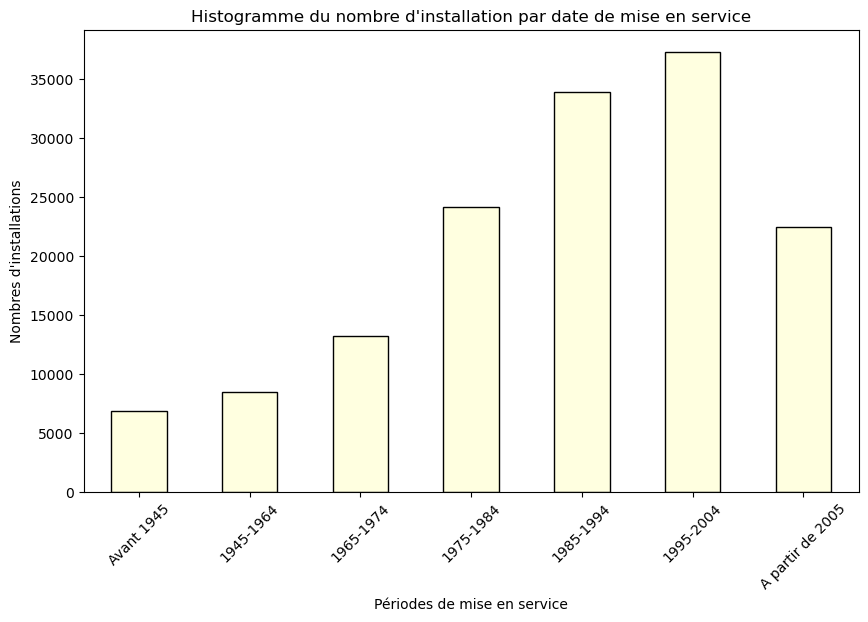

Part de données libellées : 0.8919867634422364


In [85]:
# Compter les occurrences de chaque période de mise en service
period_counts = df_es['equip_service_periode'].value_counts()

# Ordre croissant
sorted_index = ['A partir de 2005'] + [p for p in period_counts.index if p != 'A partir de 2005']
period_counts = period_counts.reindex(sorted_index[::-1])

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
period_counts.plot(kind='bar', color='#FFFFE0', edgecolor='black')
plt.title('Histogramme du nombre d\'installation par date de mise en service')
plt.xlabel('Périodes de mise en service')
plt.ylabel('Nombres d\'installations')
plt.xticks(rotation=45)
plt.show()

print('Part de données libellées :', period_counts.sum() / len(df_es))

Cet histogramme renseigne sur la date de mise en service des infrastructures sportives sur plusieurs périodes temporelles depuis 1945.
La grande majorité des infrastructures ont été mises en service à partir de 1975, et le nombre de mise en service d'infrastructures est croissant sur tout notre graphique, sauf entre la période 1995-2004 et à partir de 2005. Ainsi, on a des infrastructures dont l'ancienneté est assez hétérogène, 

### VARIABLE EQUIP_TYPE_FAMILLE
 Quelques analyses de equip_type_name

/tmp/ipykernel_37288/1184851496.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Var1', y='Freq', data=freq_table.sort_values('Freq', ascending=False), palette='winter')


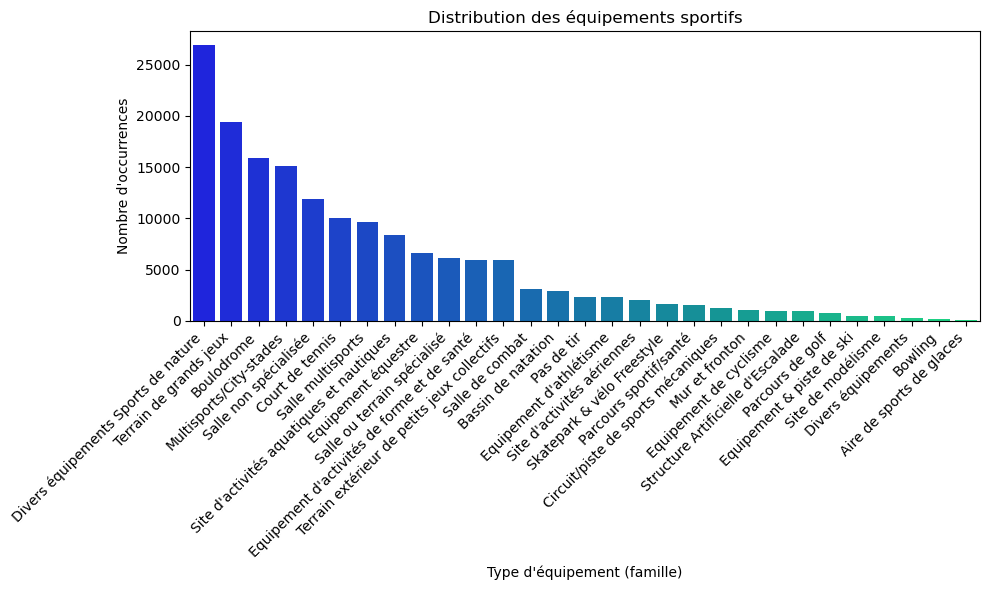

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une table de fréquences
freq_table = pd.DataFrame(df_es['equip_type_famille'].value_counts()).reset_index()
freq_table.columns = ['Var1', 'Freq']

# Visualiser avec un barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Var1', y='Freq', data=freq_table.sort_values('Freq', ascending=False), palette='winter')
plt.title("Distribution des équipements sportifs")
plt.xlabel("Type d'équipement (famille)")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Cet histogramme représente la distribution de notre variables d'intérêt - equip_type_famille -, qui a pour modalité le type d'équipement sportif de l'infrastructure en question, autrement dit à un niveau de détail moins important que la variable equip_nom qui donne le nom usuel de l'infrastructure.
Cette variable est composée de 29 familles d'équipements, et on peut déjà commenter quelques points par rapport à la construction de la base de données et à la catégorisation des équipements. Certaines familles donnent un niveau de détail qui permet de savoir quel sport est pratiqué à cet endroit : par exemple, la famille "Bowling" donne directement l'activité, tandis que la famille "Divers équipements Sports de nature" rassemble des activités physiques et sportives variées.
Quelques points peuvent paraître surprenant. On aurait pu penser que les piscines auraient fait partie des équipements sportifs les plus présents en France, or le bassin de natation apparaît loin derrière le court de tennis par exemple, ou le boulodrome, ce qui, compte tenu de la taille de l'infrastructure et l'accessibilité, est moins étonnant.
On remarque à cet égard que plus le libellé de la modalité est vague et plus cette famille rassemble des infrastructures : "Divers équipements Sports de nature", "Terrain de grands jeux", "Salle non spécialisée", "Salle multisports". Il serait donc intéressant d'aller au détail de quelques une de ces modalités pour voir les sous-modalités associées à ces familles.

In [87]:
df_es_terrain_grands_jeux = df_es[df_es['equip_type_famille'] == 'Terrain de grands jeux'].copy()

# Comptage des occurrences de chaque modalité dans la colonne 'equip_type_name'
tableau_comptage = df_es_terrain_grands_jeux['equip_type_name'].value_counts().reset_index()

# Renommer les colonnes pour plus de clarté
tableau_comptage.columns = ['Nom du type d\'équipement', 'Fréquence']

# Afficher le tableau
print(tableau_comptage)

        Nom du type d'équipement  Fréquence
0            Terrain de football      17430
1                  Terrain mixte        986
2               Terrain de rugby        911
3  Terrain de baseball /softball         42
4        Terrain de rugby à XIII         22
5    Terrain de hockey sur gazon         17
6             Terrain de cricket          8
7  Terrain de football américain          5


Si on s'intéresse uniquement à la modalité "Terrain de grands jeux", on voit bien que cel renvoie à 8 réalités possibles, pour autant, le football y est l'activité prépondérante, avec plus de 17 fois plus de terrains de football que de terrains de rugby. Cela ne semble pas étonnant quand on sait que le football est le sport qui regroupe le plus grand nombre de licenciés, devant le tennis et l'équitation.

In [88]:
df_es_sports_nature = df_es[df_es['equip_type_famille'] == 'Divers équipements Sports de nature'].copy()

# Comptage des occurrences de chaque modalité dans la colonne 'equip_type_name'
tableau_comptage = df_es_sports_nature['equip_type_name'].value_counts().reset_index()

# Renommer les colonnes pour plus de clarté
tableau_comptage.columns = ['Nom du type d\'équipement', 'Fréquence']

# Afficher le tableau
print(tableau_comptage)

                             Nom du type d'équipement  Fréquence
0                                 Boucle de randonnée      18063
1                    Espace de pratique spéléologique       2809
2                          Site d'escalade en falaise       1750
3                                              Canyon       1290
4        Site de spéléologie sportive et/ou éducative       1035
5                                  Refuge de montagne        547
6   Parcours Acrobatique en Hauteur/Site d'accrobr...        423
7               Parcours fixe de course d’orientation        370
8                                    Cascade de glace        207
9                             Via ferrata / Via corda        134
10                           Site de blocs d'escalade        129
11                   Parcours de chasse / en campagne         65
12                               Site de char à voile         38
13                 Equipement pour saut à l’élastique         26
14                 Piste 

De la même manière, pour la modalité "Divers équipements Sports de nature", la sous-modalité principale correspond à "Boucle de randonnée", et il existe 14 autres sous-modalités pour cette famille, qui rassemblent moins d'infrastructures réunis que la principale.

In [89]:
df_es_bowling = df_es[df_es['equip_type_famille'] == 'Bowling'].copy()

# Comptage des occurrences de chaque modalité dans la colonne 'equip_type_name'
tableau_comptage = df_es_bowling['equip_type_name'].value_counts().reset_index()

# Renommer les colonnes pour plus de clarté
tableau_comptage.columns = ['Nom du type d\'équipement', 'Fréquence']

# Afficher le tableau
print(tableau_comptage)

  Nom du type d'équipement  Fréquence
0                  Bowling        218


La famille Bowling n'admet qu'une sous-modalité qui est la même que la modalité principale.

Intéressons-nous par exemple à l'accessibilité des PMR aux installations sportives

In [90]:
# Comptage des occurrences de chaque valeur unique dans la colonne 'inst_acc_handi_bool'
frequency_table = df_es['inst_acc_handi_bool'].value_counts()

# Afficher le résultat
print(frequency_table)

inst_acc_handi_bool
True     89521
False    72479
Name: count, dtype: int64


### CARTOGRAPHIE

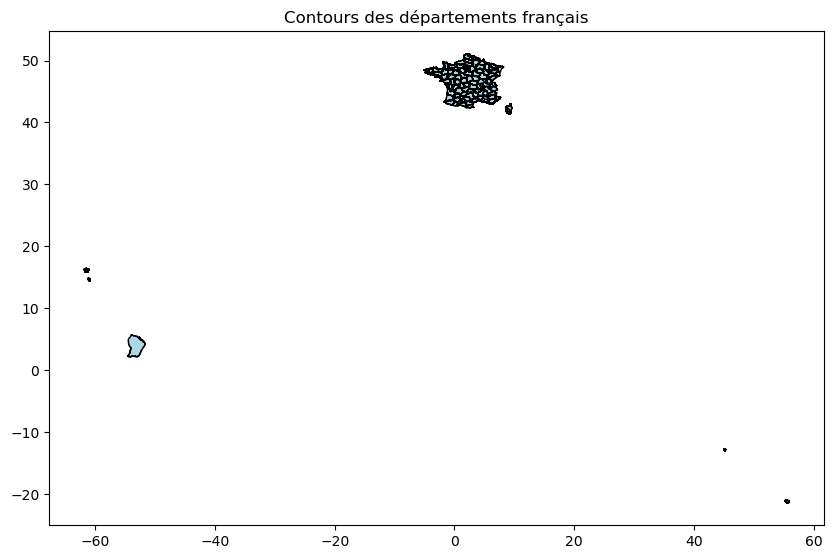

In [91]:
import requests
import geopandas as gpd
from io import BytesIO

# URL de la ressource (fichier GeoJSON)
url2 = "https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce"

# Télécharger le fichier GeoJSON
response = requests.get(url2)

# Charger le fichier dans un GeoDataFrame
gdf = gpd.read_file(BytesIO(response.content))

# Tracer la carte des départements
gdf.plot(figsize=(10, 10), edgecolor='black', color='lightblue')
plt.title("Contours des départements français")
plt.show()

On se restreint aux coordonnées géographiques de la métropole, pour avoir une carte centrée sur la métropole.

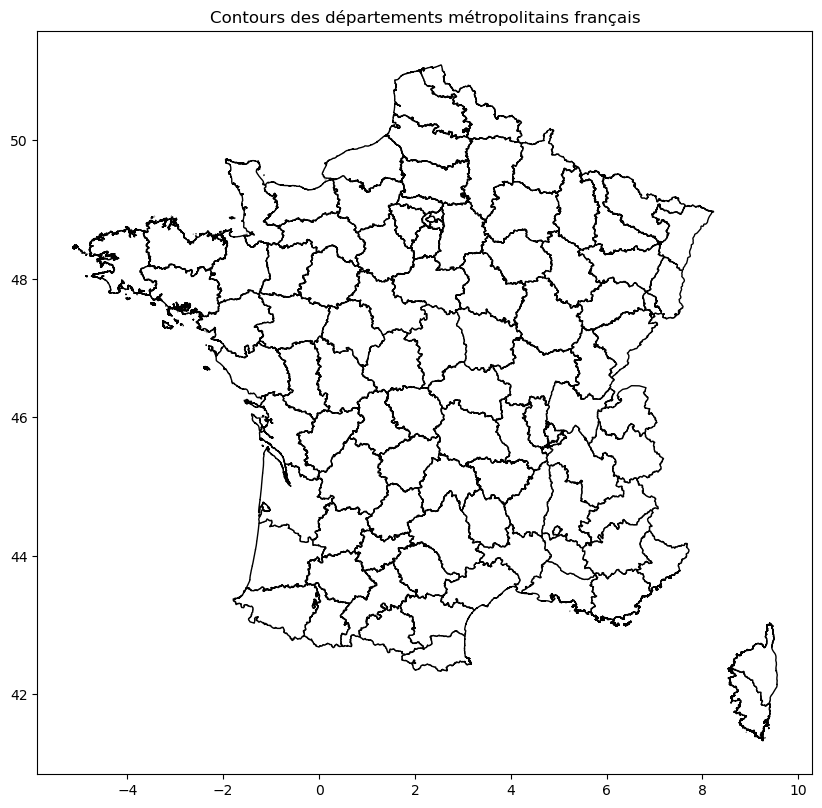

In [92]:
# Création d'un nouvel objet sans les départements d'outre-mer
gdf_metropole = gdf[~gdf['code_insee'].str.startswith('97')]  # Exclure les départements d'outre-mer
gdf_metropole.plot(figsize=(10, 10), edgecolor='black', color='white')
plt.title("Contours des départements métropolitains français")
plt.show()

/tmp/ipykernel_37288/2878713196.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20", len(equip_types))  # Table de couleurs qualitative


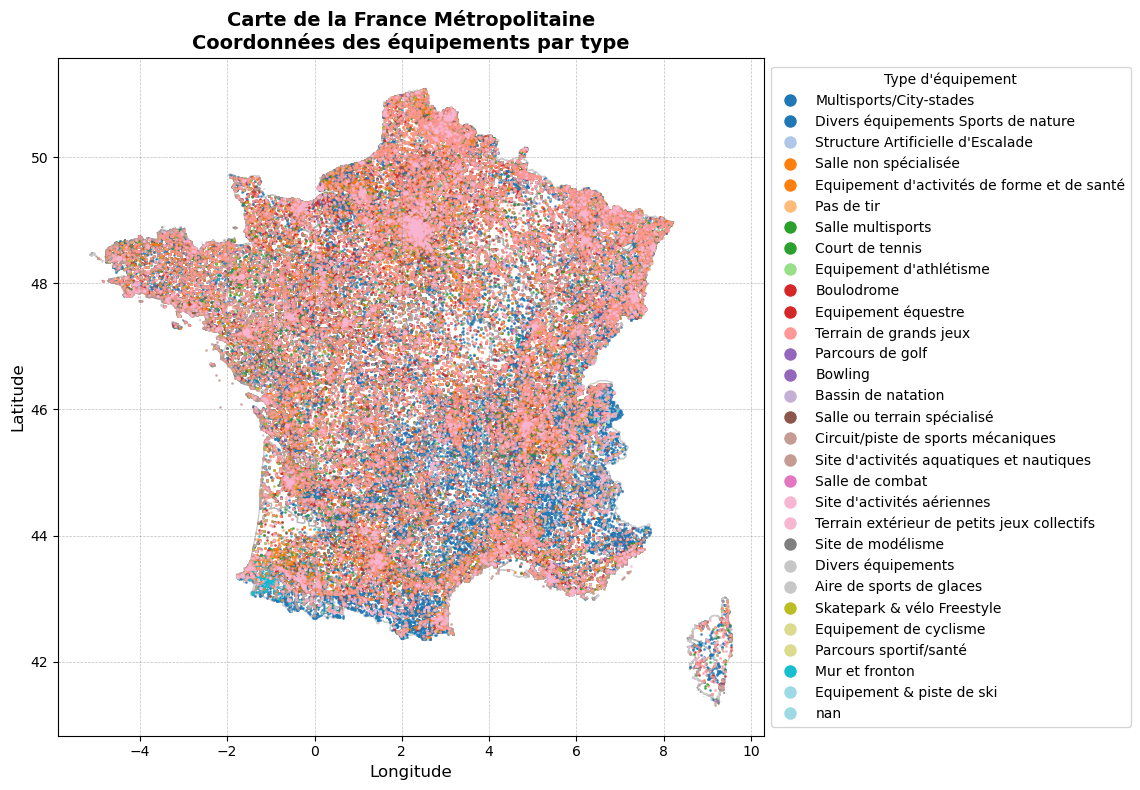

In [98]:
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
# Filtrer les points qui ne sont pas en métropole
df_es_metropole = df_es[
    (df_es['equip_x'] >= -5) & 
    (df_es['equip_x'] <= 10) & 
    (df_es['equip_y'] >= 41) & 
    (df_es['equip_y'] <= 52)
].copy()

# Générer une table de couleurs pour les familles d'équipements
equip_types = df_es_metropole['equip_type_famille'].unique()
cmap = get_cmap("tab20", len(equip_types))  # Table de couleurs qualitative
color_dict = {etype: cmap(i) for i, etype in enumerate(equip_types)}

# Attribuer des couleurs à chaque type d'équipement
df_es_metropole['color'] = df_es_metropole['equip_type_famille'].map(color_dict)

# Tracer la carte
fig, ax = plt.subplots(figsize=(12, 8))

# Fond de carte de la France métropolitaine
gdf_metropole.plot(ax=ax, color='white', edgecolor='gray', alpha=0.4)

# Tracer les points pour chaque équipement
for equip_type, group in df_es_metropole.groupby('equip_type_famille'):
    ax.scatter(
        group['equip_x'],
        group['equip_y'],
        color=color_dict[equip_type],
        s=1,  # Taille
        alpha=0.7,
        label=equip_type
    )

# Légende sur mesure avec taille des points plus grosse
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[equip_type],
           markersize=10, label=equip_type)  # Taille plus grosse
    for equip_type in df_es_metropole['equip_type_famille'].unique()
]

# Ajouter la légende sur mesure
ax.legend(
    handles=legend_handles,
    title="Type d'équipement",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

# Ajouter les informations sur la carte
plt.title('Carte de la France Métropolitaine\nCoordonnées des équipements par type', fontsize=14, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Montrer la carte
plt.show()

Nous avons tracé une carte qui affiche des points sur le territoire français. Ces points correspondents aux infrastructures recensées, et les couleurs correspondent aux différentes familles d'équipement. A partir de cette carte on peut déjà inférer quelques tendances : le rouge semble être dominant et reparti de façon assez homogène sur le territoire (tennis et foot) ; certaines parties de la France semblent accueillir moins d'infrastructures (Corse, Landes, Manche, la Camargue, diagonale du vide...) ; naturellement, le ski se concentre dans les régions montagneuses (Massif central, Pyrénées, Alpes) ; le rose se situe au niveau des littoraux (activités nautiques/aquatiques) ; concentration de rose en IdF (terrain extérieur de petits jeux collectifs) ; mur et fronton au pays basque

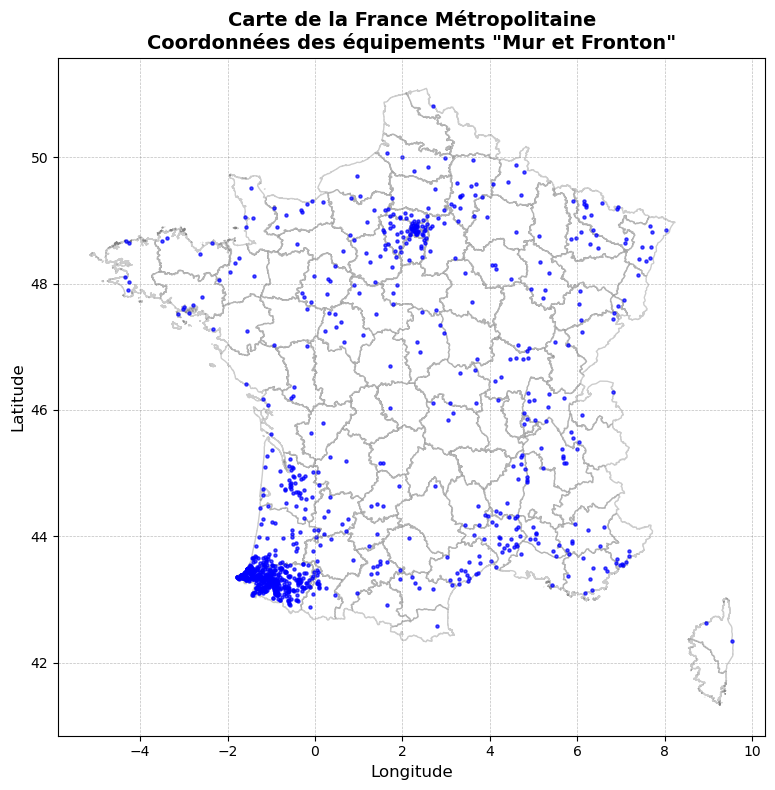

In [ ]:
# Filtrer les points qui ne sont pas en métropole
df_es_metropole = df_es[
    (df_es['equip_x'] >= -5) & 
    (df_es['equip_x'] <= 10) & 
    (df_es['equip_y'] >= 41) & 
    (df_es['equip_y'] <= 52)
].copy()

# Restreindre aux modalités "Mur et fronton"
df_es_metropole_fronton = df_es_metropole[df_es_metropole['equip_type_famille'].isin(['Mur et fronton'])]

# Tracer la carte
fig, ax = plt.subplots(figsize=(12, 8))

# Fond de carte de la France métropolitaine
gdf_metropole.plot(ax=ax, color='white', edgecolor='gray', alpha=0.4)

# Tracer les points pour le type "Mur et fronton"
ax.scatter(
    df_es_metropole_fronton['equip_x'],
    df_es_metropole_fronton['equip_y'],
    color= 'blue',
    s=5,  # Taille des points
    alpha=0.7,
    label='Mur et fronton'
)

# Ajouter les informations sur la carte
plt.title('Carte de la France Métropolitaine\nCoordonnées des équipements "Mur et Fronton"', fontsize=14, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Montrer la carte
plt.show()

Quand on ne trace que les points associés à la famille d'équipements "Mur et fronton", et la carte confirme notre intuition, que les murs et frontons sont concentrés dans le sud-est, là où la pelote basque y est très développée par exemple. Aussi, il y en a beaucoup à Paris, ce qui ne nous étonne pas car il y a aussi des murs simples de tennis dans cette modalité, et l'espace et la demande font qu'il y en a en IdF.

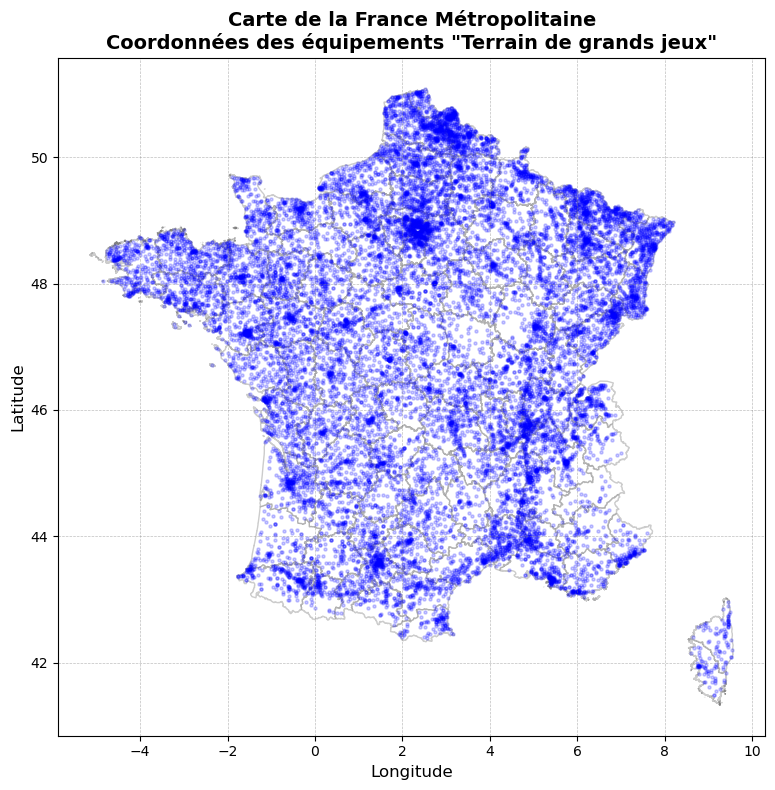

In [105]:
# Restreindre aux modalités "Terrain de grands jeux"
df_es_metropole_foot = df_es_metropole[df_es_metropole['equip_type_famille'].isin(['Terrain de grands jeux'])]

# Tracer la carte
fig, ax = plt.subplots(figsize=(12, 8))

# Fond de carte de la France métropolitaine
gdf_metropole.plot(ax=ax, color='white', edgecolor='gray', alpha=0.4)

# Tracer les points pour le type "Terrain de grands jeux"
ax.scatter(
    df_es_metropole_foot['equip_x'],
    df_es_metropole_foot['equip_y'],
    color= 'blue',
    s=5,  # Taille des points
    alpha=0.2,
    label='Terrain de grands jeux'
)

# Ajouter les informations sur la carte
plt.title('Carte de la France Métropolitaine\nCoordonnées des équipements "Terrain de grands jeux"', fontsize=14, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Montrer la carte
plt.show()

Pour les terrains de grands jeux, qui regroupent en particulier les terrains de football, on voit des concentrations au niveau des grandes villes françaises, ainsi que dans le Nord et l'Est.

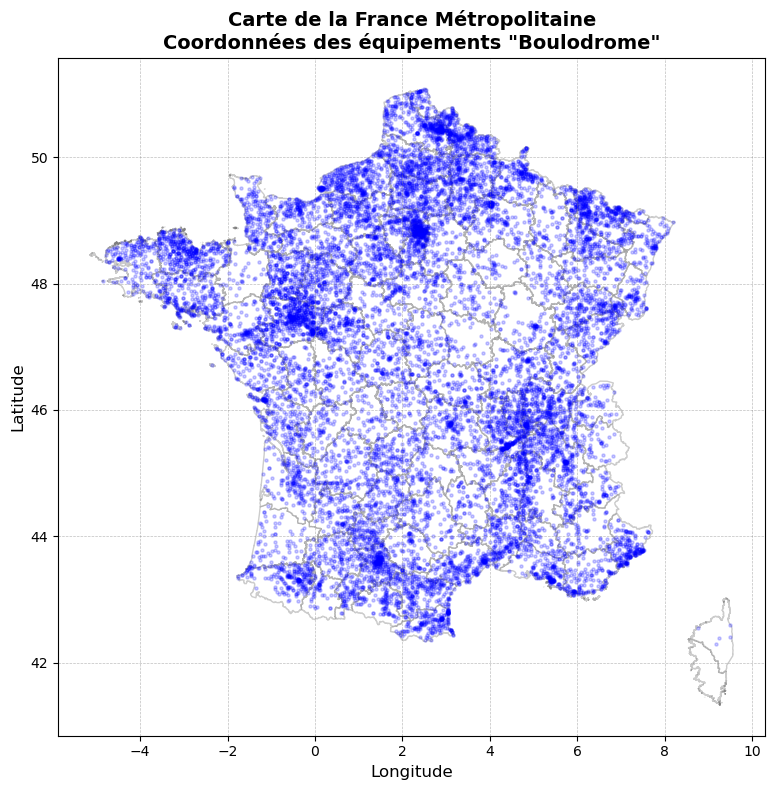

In [ ]:
# Restreindre aux modalités "Terrain de grands jeux"
df_es_metropole_boulodrome = df_es_metropole[df_es_metropole['equip_type_famille'].isin(['Boulodrome'])]

# Tracer la carte
fig, ax = plt.subplots(figsize=(12, 8))

# Fond de carte de la France métropolitaine
gdf_metropole.plot(ax=ax, color='white', edgecolor='gray', alpha=0.4)

# Tracer les points pour le type "Terrain de grands jeux"
ax.scatter(
    df_es_metropole_boulodrome['equip_x'],
    df_es_metropole_boulodrome['equip_y'],
    color= 'blue',
    s=5,  # Taille des points
    alpha=0.2,
    label='Boulodrome'
)

# Ajouter les informations sur la carte
plt.title('Carte de la France Métropolitaine\nCoordonnées des équipements "Boulodrome"', fontsize=14, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Montrer la carte
plt.show()

Pour les boulodromes, on voit aussi des disparités régionales, qui correspondent aux différents jeu de boule. Dans le sud est et dans le Nord, on joue à la pétanque, mais des jeux tels que la boule lyonnaise dans le Dauphiné ou la boule nantaise dans la région du Val-de-Loire. La sous-estimation de la pétanque dans le sud peut-être due à la non comptabilisation des terrains privés.

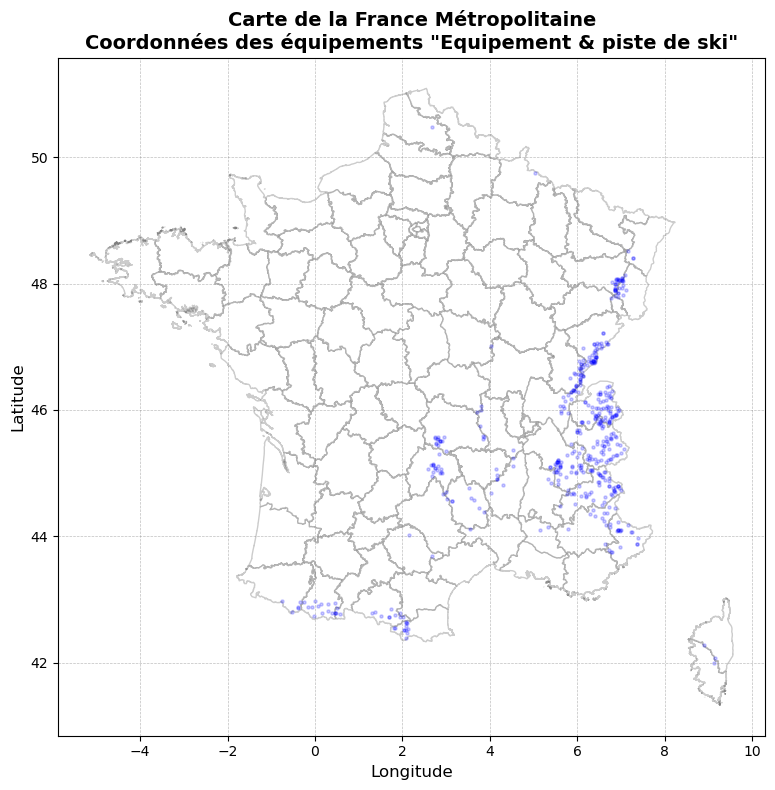

In [106]:
# Restreindre aux modalités "Terrain de grands jeux"
df_es_metropole_ski = df_es_metropole[df_es_metropole['equip_type_famille'].isin(['Equipement & piste de ski'])]

# Tracer la carte
fig, ax = plt.subplots(figsize=(12, 8))

# Fond de carte de la France métropolitaine
gdf_metropole.plot(ax=ax, color='white', edgecolor='gray', alpha=0.4)

# Tracer les points pour le type "Terrain de grands jeux"
ax.scatter(
    df_es_metropole_ski['equip_x'],
    df_es_metropole_ski['equip_y'],
    color= 'blue',
    s=5,  # Taille des points
    alpha=0.2,
    label='Equipement & piste de ski'
)

# Ajouter les informations sur la carte
plt.title('Carte de la France Métropolitaine\nCoordonnées des équipements "Equipement & piste de ski"', fontsize=14, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Montrer la carte
plt.show()

Les équipements de ski sont concentrées dans les régions montagneuses.

### TRIS CROISES

Utiliser les données économiques aussi, pas encore d'analyse menées dessus
inst_acc_handi_bool
equip_pmr_aire
dens_lib